In [6]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
# from https://medium.com/@msgold/using-python-to-create-and-solve-mazes-672285723c96
def create_maze(dim: int) -> np.array:
    # Create a grid filled with walls
    maze = np.ones((dim*2+1, dim*2+1))

    # Define the starting point
    x, y = (0, 0)
    maze[2*x+1, 2*y+1] = 0

    # Initialize the stack with the starting point
    stack = [(x, y)]
    while len(stack) > 0:
        x, y = stack[-1]

        # Define possible directions
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        random.shuffle(directions)

        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if nx >= 0 and ny >= 0 and nx < dim and ny < dim and maze[2*nx+1, 2*ny+1] == 1:
                maze[2*nx+1, 2*ny+1] = 0
                maze[2*x+1+dx, 2*y+1+dy] = 0
                stack.append((nx, ny))
                break
        else:
            stack.pop()
            
    # Create an entrance and an exit
    maze[1, 0] = 0
    maze[-2, -1] = 0

    return maze

In [8]:
class MazeEnv():
    def __init__(self, dim):
        self.grid = create_maze(dim)
        self.start_state = [1, 0]
        self.goal_state = [19, 20]

        empty_cells = np.where(self.grid == 0.0)
        self.state_space = [[col, row] for row, col in zip(empty_cells[0], empty_cells[1])]
        self.num_states = len(self.state_space)

        self.actions = {"up": [-1, 0],
                        "down": [1, 0],
                        "left": [0, -1],
                        "right": [0, 1]}

        self.action_space = list(self.actions.keys())
        self.num_actions = len(self.action_space)

        self.state = self.start_state

    def reset(self):
        self.state = self.start_state
        return self.state

    def step(self, action):
        if action not in self.action_space:
            raise ValueError(f"invalid action: {action}")
        next_state = [self.state[0] + self.actions[action][0], self.state[1] + self.actions[action][1]]

        # if next state is a wall, state doesn't change
        if self.grid[tuple(next_state)] == 0:
            next_state = self.state

        reward = 0
        done = False
        # reach goal
        if next_state == self.goal_state:
            reward = 1
            done = True
        # leave maze (left from start cell)
        elif next_state[1] == -1:
            reward = -1
            done = True
        
        return next_state, reward, done

    def render(self):
        plt.imshow(self.grid)

Figure 13 shows the baseline network architectures for DQN and SAC. The RAD (Laskin et al.,
2020a) Crop baselines, CURL (Laskin et al., 2020b) baselines, and FERM (Zhan et al., 2020) baselines use random crop for data augmentation. The random crop crops a 142 × 142 state image to
the size of 128 × 128. The contrastive encoder of CURL baselines has a size of 128 as in Laskin
et al. (2020b), and that for the FERM baselines has a size of 50 as in Zhan et al. (2020). The FERM
baseline’s contrastive encoder is pretrained for 1.6k steps using the expert data as in Zhan et al.
(2020). The DrQ (Kostrikov et al., 2020) Shift baselines use random shift of ±4 pixels for data augmentation as in the original work. In all DrQ baselines, the number of augmentations for calculating
the target K and the number of augmentations for calculating the loss M are both 2 as in Kostrikov
et al. (2020).

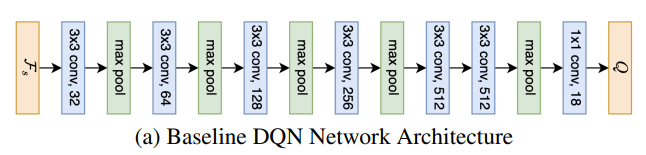

In [11]:
class ExponentialSchedule:
    def __init__(self, value_from, value_to, num_steps):
        """Exponential schedule from `value_from` to `value_to` in `num_steps` steps.

        $value(t) = a \exp (b t)$

        :param value_from: Initial value
        :param value_to: Final value
        :param num_steps: Number of steps for the exponential schedule
        """
        self.value_from = value_from
        self.value_to = value_to
        self.num_steps = num_steps

        # YOUR CODE HERE: Determine the `a` and `b` parameters such that the schedule is correct
        self.a = value_from
        self.b = 1/(num_steps-1) * np.log(value_to/self.a)
        

    def value(self, step) -> float:
        """Return exponentially interpolated value between `value_from` and `value_to`interpolated value between.

        Returns {
            `value_from`, if step == 0 or less
            `value_to`, if step == num_steps - 1 or more
            the exponential interpolation between `value_from` and `value_to`, if 0 <= steps < num_steps
        }

        :param step: The step at which to compute the interpolation
        :rtype: Float. The interpolated value
        """

        # YOUR CODE HERE: Implement the schedule rule as described in the docstring,
        # using attributes `self.a` and `self.b`.
        if step <= 0:
            value = self.value_from
        elif step >= self.num_steps-1:
            value = self.value_to
        else:
            value = self.a * np.exp(self.b * step)
        
        return value
        
class DQNBase(nn.Module):
    """Class for baseline DQN network. Same as EquiDQN but with CNN instead of equivariant network."""
    def __init__(self, input_shape=(2, 128, 128), n_p=2, n_theta=1):
        super().__init__()
        self.n_inv = 3 * n_theta * n_p
        self.layers = torch.nn.Sequential(
            # input -> 32
            nn.Conv2d(input_shape[0], 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # 32 -> 64
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # 64 -> 128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # 128 -> 256
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # 256 -> 512 -> 512
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # 512 -> 18
            nn.Conv2d(512, 18, kernel_size=1, padding=0),
        )

        self.n_p = n_p
        self.n_theta = n_theta

        for m in self.named_modules():
            if isinstance(m[1], nn.Conv2d):
                # nn.init.kaiming_normal_(m[1].weight.data)
                nn.init.xavier_normal_(m[1].weight.data)
            elif isinstance(m[1], nn.BatchNorm2d):
                m[1].weight.data.fill_(1)
                m[1].bias.data.zero_()

    def forward(self, x):
        batch_size = x.shape[0]
        q = self.layers(x)
        q = q.reshape(batch_size, self.n_inv, 9).permute(0, 2, 1)
        return q

def batch_update(optimizer, batch, dqn_model, dqn_target, gamma) -> float:
    """Perform a single batch-update step on the given DQN model.

    :param optimizer: nn.optim.Optimizer instance
    :param batch: Batch of experiences (class defined earlier)
    :param dqn_model: The DQN model to be trained
    :param dqn_target: The target DQN model, ~NOT~ to be trained
    :param gamma: The discount factor
    :rtype: Float. The scalar loss associated with this batch
    """
    
    values = dqn_model(batch.states).gather(1, batch.actions)

    with torch.no_grad():
        next_q = dqn_target(batch.next_states).max(1)[0].view(-1, 1)
        target_values = batch.rewards + gamma * next_q * (~batch.dones)

    assert (
        values.shape == target_values.shape
    ), 'Shapes of values tensor and target_values tensor do not match.'

    # Testing that the values tensor requires a gradient,
    # and the target_values tensor does not
    assert values.requires_grad, 'values tensor requires gradients'
    assert (
        not target_values.requires_grad
    ), 'target_values tensor should not require gradients'

    loss = F.HuberLoss(values, target_values)

    optimizer.zero_grad()  # Reset all previous gradients
    loss.backward()  # Compute new gradients
    optimizer.step()  # Perform one gradient-descent step

    return loss.item()

def train_dqn(
    env,
    num_steps,
    *,
    num_saves=5,
    replay_size,
    replay_prepopulate_steps=0,
    batch_size,
    exploration,
    gamma,
):
    """
    DQN algorithm.

    Compared to previous training procedures, we will train for a given number
    of time-steps rather than a given number of episodes. The number of
    time-steps will be in the range of millions, which still results in many
    episodes being executed.

    Args:
        - env: The Gymnasium environment
        - num_steps: Total number of steps to be used for training
        - num_saves: How many models to save to analyze the training progress
        - replay_size: Maximum size of the ReplayMemory
        - replay_prepopulate_steps: Number of steps with which to prepopulate
                                    the memory
        - batch_size: Number of experiences in a batch
        - exploration: An ExponentialSchedule
        - gamma: The discount factor

    Returns: (saved_models, returns)
        - saved_models: Dictionary whose values are trained DQN models
        - returns: Numpy array containing the return of each training episode
        - lengths: Numpy array containing the length of each training episode
        - losses: Numpy array containing the loss of each training batch
    """
    # Initialize the DQN and DQN-target models
    dqn_model = DQNBase(env.num_states, env.num_actions)
    dqn_target = DQNBase.custom_load(dqn_model.custom_dump())

    # Initialize the optimizer
    optimizer = torch.optim.Adam(dqn_model.parameters())

    # Initialize the replay memory and prepopulate it
    memory = ReplayMemory(replay_size, state_size)
    memory.populate(env, replay_prepopulate_steps)

    # Initialize lists to store returns, lengths, and losses
    rewards = []
    returns = []
    lengths = []
    losses = []

    # Initialize structures to store the models at different stages of training
    t_saves = np.linspace(0, num_steps, num_saves - 1, endpoint=False)
    saved_models = {}

    i_episode = 0  # Use this to indicate the index of the current episode
    t_episode = 0  # Use this to indicate the time-step inside current episode

    state, info = env.reset()  # Initialize state of first episode
    G=0

    # Iterate for a total of `num_steps` steps
    pbar = tqdm.trange(num_steps)
    for t_total in pbar:
        # Use t_total to indicate the time-step from the beginning of training

        # Save model
        if t_total in t_saves:
            model_name = f'{100 * t_total / num_steps:04.1f}'.replace('.', '_')
            saved_models[model_name] = copy.deepcopy(dqn_model)

        # get action using e-greedy
        eps = exploration.value(t_total)  # get current epsilon value
        if np.random.rand() < eps:
            action = np.random.choice(env.action_space)
        else:
            with torch.no_grad():
                q_values = dqn_model(torch.tensor(state, dtype=torch.float32))
                max_q_idx = torch.where(q_values == q_values.max())[0]
                action = np.random.choice(max_q_idx.tolist())
            
        # step forward env
        next_state, reward, done = env.step(action)

        # add transition to memory
        memory.add(state, action, reward, next_state, done)
        
        if t_total%4 == 0:
            batch = memory.sample(batch_size)
            loss = train_dqn_batch(optimizer, batch, dqn_model, dqn_target, gamma)
            losses.append(loss)

        if t_total%10000 == 0:
            dqn_target.load_state_dict(dqn_model.state_dict())

        if done:
            G = 0
            for r in rewards[::-1]:
                G = gamma * G + r

            returns.append(G)
            lengths.append(t_episode)

            pbar.set_description(
                f'Episode: {i_episode} | Steps: {t_episode + 1} | Return: {G:5.2f} | Epsilon: {eps:4.2f}'
            )

            # reset
            t_episode = 0
            i_episode += 1
            rewards = []
            state, _ = env.reset()
            
        else:
            # YOUR CODE HERE: Anything you need to do within an episode
            state = next_state
            t_episode += 1
            rewards.append(reward)

    saved_models['100_0'] = copy.deepcopy(dqn_model)

    return (
        saved_models,
        np.array(returns),
        np.array(lengths),
        np.array(losses),
    )

In [12]:
env = MazeEnv(10)
env.reset()
gamma = 0.99

# We train for many time-steps; as usual, you can decrease this during development / debugging,
# but make sure to restore it to 1_500_000 before submitting
num_steps = 1_000
num_saves = 5  # Save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.05, 1_000_000)

# This should take about 1-2 hours on a generic 4-core laptop
dqn_models, returns, lengths, losses = train_dqn(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
)

assert len(dqn_models) == num_saves
assert all(isinstance(value, DQN) for value in dqn_models.values())

# Saving computed models to disk, so that we can load and visualize them later
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models.items()}
torch.save(checkpoint, f'checkpoint_maze.pt')

TypeError: 'int' object is not subscriptable

In the Equivariant DQN, we use a 7-layer Steerable CNN defined in the group C4 (Figure 12a). The
input Fs is encoded as a 2-channel ρ0 feature map, and the output is a 18-channel 3 × 3 ρ0 feature
map where the channel encodes the invariant actions Ainv and the spatial dimension encodes Axy.

In [27]:
env.step("right")

([1, 0], 0, False)

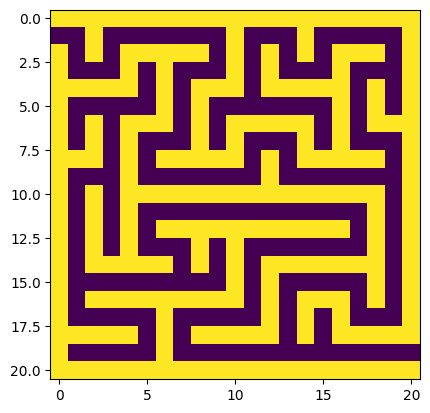

In [17]:
random.seed(123)
env = MazeEnv(10)
env.render()